# Librerías para Data Augmentation

Si bien hemos visto que Pytorch incluye, dentro de su paquete `torchvision` un set de funciones para realizar Data Augmentation, existen otras librerias independientes las cuales pueden integrarse en el flujo de trabajo ya conocido de Pytorch. Estas libreria ofrecen ciertas ventajas sobre el paquete `torchvision` como ser mayor velocidad de procesamiento del pipeline o transformaciones extras.

El objetivo de este Colab es mostrar ejemplos de uso de algunas de ellas y comparar su performance en cuanto a tiempo de ejecucion de el mismo set de transformaciones.

In [ ]:
!pip install torchmetrics
!pip install --upgrade --no-cache-dir gdown

In [ ]:
import torch
import torchvision
import torchsummary
import torchmetrics
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

Descargo el mismo dataset de perros y gatos para utilizarlo como ejemplo en este colab.

In [ ]:
# https://drive.google.com/file/d/1bx73wWKNgxFZ6sSFSeaKBVcuGtdraKh/view?usp=sharing
# El ID sera: 1bx73wWKNgxFZ6sSFSeaKBVcuGtdraKh-
!gdown 1bx73wWKNgxFZ6sSFSeaKBVcuGtdraKh-
!unzip perros_y_gatos.zip > /dev/null -d ./dataset_perros_y_gatos

Defino variables asociadas al dataset

In [ ]:
CANTIDAD_CLASES = 2
ANCHO_IMAGENES = 150
ALTO_IMAGENES = 150

## Albumentations

La librería [Albumentations](https://albumentations.ai/) provee una amplia variedad de funciones con todo tipo de transformaciones junto con una [herramienta online](https://demo.albumentations.ai/) para probar y previsualizar los resultados de las mismas, sin embargo, una de las principales ventajas es la optimizacion del tiempo de computo.

Para utilizar esta libreria debemos definir nuestra propia clase que hereda de `Dataset` dado que la composicion de transformaciones que podemos generar con Albumentations no es compatible con los objetos `Dataset` que tiene predefinidos Pytorch. Por ejemplo, la clase que se implementa a continuación tiene el mismo compotamiento que [`ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html?highlight=imagefolder#torchvision.datasets.ImageFolder) de Pytorch.

In [ ]:
import os
import cv2
import numpy as np

from torch.utils.data import Dataset
from PIL import Image

class AlbumImageFolder(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.samples = []

        classes = sorted(entry.name for entry in os.scandir(self.root) if entry.is_dir())
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

        for target_class in sorted(class_to_idx.keys()):
            class_index = class_to_idx[target_class]
            target_dir = os.path.join(self.root, target_class)
            for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    item = path, class_index
                    self.samples.append(item)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        label = self.samples[idx][-1]
        file_path = self.samples[idx][0]

        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image=image)["image"]

        return image, label

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

albumentations_aug_data_transforms = A.Compose([
                                        A.Resize(ANCHO_IMAGENES, ALTO_IMAGENES),
                                        A.HorizontalFlip(0.5),
                                        A.ShiftScaleRotate(rotate_limit=30, border_mode=0),
                                        A.RandomResizedCrop(ANCHO_IMAGENES, ALTO_IMAGENES, scale=(0.5, 1.0)),
                                        A.ColorJitter(saturation=0.2, hue=0.2),
                                        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                                        ToTensorV2(),
                                     ])

albumentations_data_transforms = A.Compose([
                                    A.Resize(ANCHO_IMAGENES, ALTO_IMAGENES),
                                    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                                    ToTensorV2()
                                 ])

albumentations_train_set = AlbumImageFolder(root='./dataset_perros_y_gatos/train', transform=albumentations_aug_data_transforms)
albumentations_valid_set = AlbumImageFolder(root='./dataset_perros_y_gatos/validation', transform=albumentations_data_transforms)

albu_train_loader = torch.utils.data.DataLoader(albumentations_train_set, batch_size=32, shuffle=True)
albu_valid_loader = torch.utils.data.DataLoader(albumentations_valid_set, batch_size=32, shuffle=True)

albu_test_loader = torch.utils.data.DataLoader(albumentations_train_set, batch_size=1, shuffle=True)

# imgaug

Otra librería para data augmentation es [imgaug](https://imgaug.readthedocs.io/en/latest/index.html). La misma tambien implementa una gran variedad de metodos para realizar transformaciones sobre imagenes y sus etiquetas, en el caso que fuera necesario.

In [ ]:
import os
import numpy as np

from torch.utils.data import Dataset
from PIL import Image

class ImgaugImageFolder(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.samples = []

        classes = sorted(entry.name for entry in os.scandir(self.root) if entry.is_dir())
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

        for target_class in sorted(class_to_idx.keys()):
            class_index = class_to_idx[target_class]
            target_dir = os.path.join(self.root, target_class)
            for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    item = path, class_index
                    self.samples.append(item)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        label = self.samples[idx][-1]
        file_path = self.samples[idx][0]

        image = np.array(Image.open(file_path))

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
from imgaug import augmenters as iaa

imgaug_aug_data_transforms = torchvision.transforms.Compose([
                                iaa.Sequential([
                                    iaa.Resize({"height": ALTO_IMAGENES, "width": ANCHO_IMAGENES}),
                                    iaa.flip.Fliplr(p=0.5),
                                    iaa.Rotate(rotate=(-30, 30)),
                                    iaa.Crop(percent=(0.0, 0.2), keep_size=True),
                                    iaa.MultiplyHueAndSaturation((0.8, 1.2))
                                ]).augment_image,
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                             ])

imgaug_data_transforms = torchvision.transforms.Compose([
                            iaa.Sequential([
                                iaa.Resize({"height": ALTO_IMAGENES, "width": ANCHO_IMAGENES}),
                            ]).augment_image,
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         ])

imgaug_train_set = ImgaugImageFolder(root='./dataset_perros_y_gatos/train', transform=imgaug_aug_data_transforms)
imgaug_valid_set = ImgaugImageFolder(root='./dataset_perros_y_gatos/validation', transform=imgaug_data_transforms)

imgaug_train_loader = torch.utils.data.DataLoader(imgaug_train_set, batch_size=32, shuffle=True)
imgaug_valid_loader = torch.utils.data.DataLoader(imgaug_valid_set, batch_size=32, shuffle=True)

imgaug_test_loader = torch.utils.data.DataLoader(imgaug_train_set, batch_size=1, shuffle=True)

## Torchvision

In [ ]:
torchvision_aug_data_transforms = torchvision.transforms.Compose([
                                    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                                    torchvision.transforms.RandomHorizontalFlip(0.5),
                                    torchvision.transforms.RandomRotation(30),
                                    torchvision.transforms.RandomResizedCrop(size=(ANCHO_IMAGENES, ALTO_IMAGENES), scale=(0.5, 1.0)),
                                    torchvision.transforms.ColorJitter(saturation=0.1, hue=0.1),
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                                  ])

torchvision_data_transforms = torchvision.transforms.Compose([
                                torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                              ])

torchvision_train_set = torchvision.datasets.ImageFolder(root='./dataset_perros_y_gatos/train', transform=torchvision_aug_data_transforms)
torchvision_valid_set = torchvision.datasets.ImageFolder(root='./dataset_perros_y_gatos/validation', transform=torchvision_data_transforms)

torchvision_train_loader = torch.utils.data.DataLoader(torchvision_train_set, batch_size=32, shuffle=True)
torchvision_valid_loader = torch.utils.data.DataLoader(torchvision_valid_set, batch_size=32, shuffle=True)

torchvision_test_loader = torch.utils.data.DataLoader(torchvision_train_set, batch_size=1, shuffle=True)

## Comparando tiempo de computo

A pesar de la practicidad de `torchvision`, por no requerir obligatoriamente de la implementacion de una clase `Dataset`, la mayoria de las demas librerias existentes cuentan con mejor performance en cuanto al tiempo de computo, lo cual se torna importante cuando el tamaño del dataset de entrenamiento y la red neuronal

In [ ]:
import time

start_time = time.time()
for i in range(3000):
  image, label = next(iter(torchvision_test_loader))
end_time = time.time()

print("Torchvision time/sample: {} ms".format(end_time - start_time))

start_time = time.time()
for i in range(3000):
  image, label = next(iter(albu_test_loader))
end_time = time.time()

print("Albumentations time/sample: {} ms".format(end_time - start_time))

start_time = time.time()
for i in range(3000):
  image, label = next(iter(imgaug_test_loader))
end_time = time.time()

print("imgaug time/sample: {} ms".format(end_time - start_time))

Torchvision time/sample: 18.524526357650757 ms
Albumentations time/sample: 12.794373512268066 ms
imgaug time/sample: 19.211326360702515 ms


## Comparando transformaciones

A continuacion se plotea un conjunto de imagenes del dataset y las transformaciones aplicadas por cada una de las librerias a dichas imagenes.
Simepre, es fundamental hacer verificaciones de como se comporta nuestro pipeline de transformaciones para evitar problemas durante el entrenamiento!

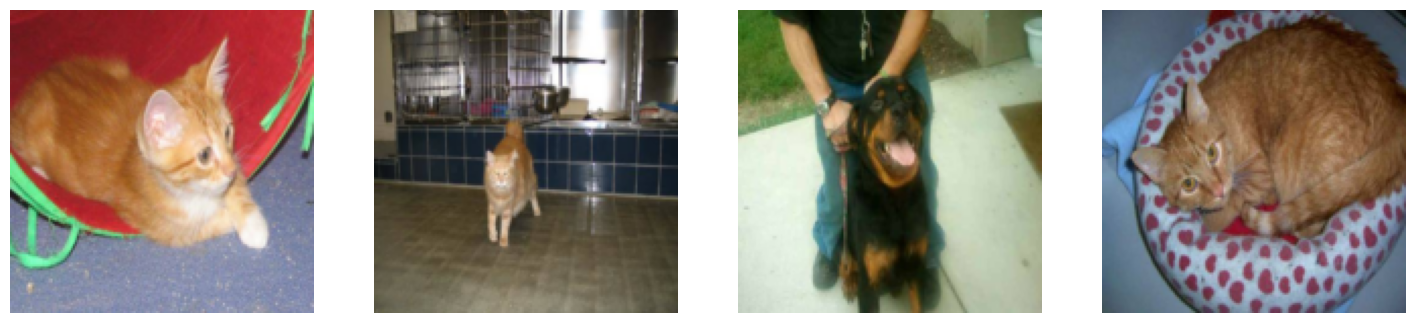

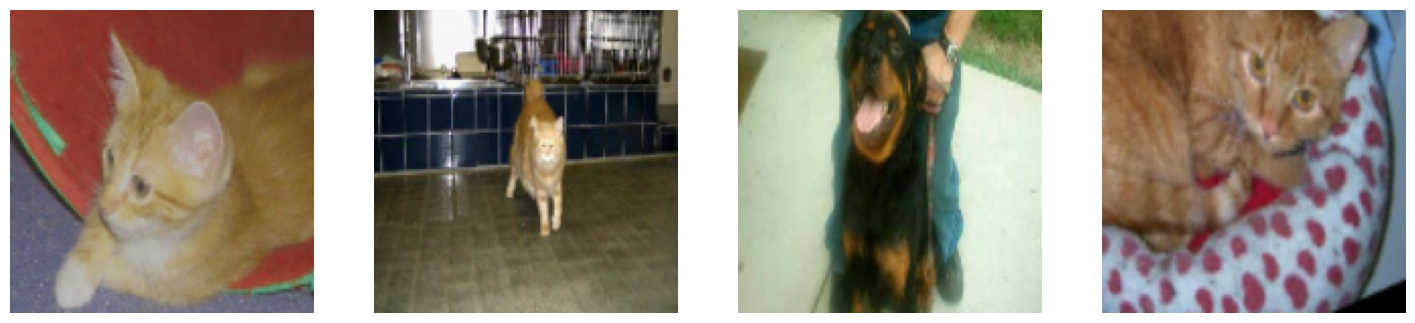

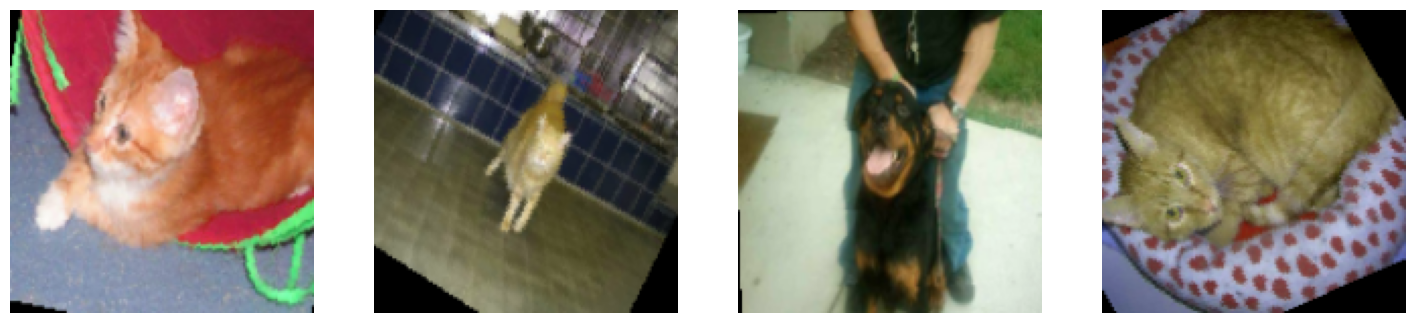

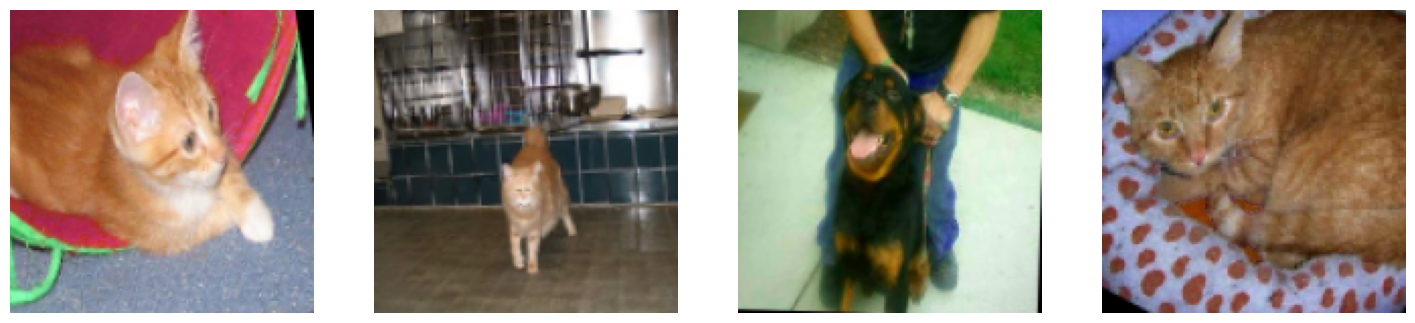

In [ ]:
import numpy as np

mean = torch.tensor((0.5, 0.5, 0.5), dtype=torch.float32)
std = torch.tensor((0.5, 0.5, 0.5), dtype=torch.float32)

train_set = torchvision.datasets.ImageFolder(root='./dataset_perros_y_gatos/train', transform=torchvision_data_transforms)

# Ploteo las imagenes sin augmentacion

images_ids = np.random.randint(low=0, high=len(train_set), size=4)

fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

for id, row in enumerate(rows):
    image = train_set[images_ids[id]][0].permute(1, 2, 0)
    row.imshow(torch.clamp((image * std) + mean, min=0.0, max=1.0))
    row.axis('off')
plt.show()

# Ploteo las imagenes transformadas por Albumentations

fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

for id, row in enumerate(rows):
    image = albumentations_train_set[images_ids[id]][0].permute(1, 2, 0)
    row.imshow(torch.clamp((image * std) + mean, min=0.0, max=1.0))
    row.axis('off')
plt.show()

# Ploteo las imagenes transformadas por torchvision

fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

for id, row in enumerate(rows):
    image = torchvision_train_set[images_ids[id]][0].permute(1, 2, 0)
    row.imshow(torch.clamp((image * std) + mean, min=0.0, max=1.0))
    row.axis('off')
plt.show()

# Ploteo las imagenes transformadas por imgaug

fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

for id, row in enumerate(rows):
    image = imgaug_train_set[images_ids[id]][0].permute(1, 2, 0)
    row.imshow(torch.clamp((image * std) + mean, min=0.0, max=1.0))
    row.axis('off')
plt.show()

# Entrenando con las librerias sobre una misma red

Defino una clase para la red neuronal de ejemplo.

In [ ]:
class ConvModel(torch.nn.Module):
    def __init__(self, output_units):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same')
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(in_features=10368, out_features=512)
        self.fc2 = torch.nn.Linear(in_features=512, out_features=output_units)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.pool4(torch.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

conv_model = ConvModel(CANTIDAD_CLASES)

# Si hay una GPU disponible muevo el modelo allí para aprovechar ese recurso
if torch.cuda.is_available():
    conv_model.to("cuda")

torchsummary.summary(conv_model, (3, ANCHO_IMAGENES, ALTO_IMAGENES))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 150, 150]             448
         MaxPool2d-2           [-1, 16, 75, 75]               0
            Conv2d-3           [-1, 32, 75, 75]           4,640
         MaxPool2d-4           [-1, 32, 37, 37]               0
            Conv2d-5           [-1, 64, 37, 37]          18,496
         MaxPool2d-6           [-1, 64, 18, 18]               0
            Conv2d-7          [-1, 128, 18, 18]          73,856
         MaxPool2d-8            [-1, 128, 9, 9]               0
            Linear-9                  [-1, 512]       5,308,928
           Linear-10                    [-1, 2]           1,026
Total params: 5,407,394
Trainable params: 5,407,394
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 6.37
Params size (MB): 20.63
Estima

In [ ]:
def train(model, optimizer, criterion, metric, data, epochs, tb_writer=None):

    train_loader = data["train"]
    valid_loader = data["valid"]

    train_writer = tb_writer["train"]
    valid_writer = tb_writer["valid"]

    if tb_writer:
        train_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))
        valid_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))

    if torch.cuda.is_available():
        model.to("cuda")
        metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data.float())
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data.float())
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += metric(output, valid_target).item()

        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

        if tb_writer:
            train_writer.add_scalar("loss", epoch_train_loss, epoch)
            valid_writer.add_scalar("loss", epoch_valid_loss, epoch)
            train_writer.add_scalar("accuracy", epoch_train_accuracy, epoch)
            valid_writer.add_scalar("accuracy", epoch_valid_accuracy, epoch)
            train_writer.flush()
            valid_writer.flush()

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return history

## Entrenando con torchvision

In [ ]:
torchvision_model = ConvModel(CANTIDAD_CLASES)
torchvision_optimizer = torch.optim.Adam(torchvision_model.parameters(), lr=0.0001)
torchvision_criterion = torch.nn.CrossEntropyLoss()
torchvision_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
torchvision_data = {"train": torchvision_train_loader, "valid": torchvision_valid_loader,
                    "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

torchvision_writer = {"train": SummaryWriter(log_dir="data_aug/torchvision_train"),
                      "valid": SummaryWriter(log_dir="data_aug/torchvision_valid")}

history = train(torchvision_model,
                torchvision_optimizer,
                torchvision_criterion,
                torchvision_metric,
                torchvision_data,
                50,
                torchvision_writer)

Epoch: 1/50 - Train loss 0.692936 - Train Accuracy 0.512401 - Valid Loss 0.694629 - Valid Accuracy 0.497070
Epoch: 2/50 - Train loss 0.686593 - Train Accuracy 0.549603 - Valid Loss 0.679996 - Valid Accuracy 0.555664
Epoch: 3/50 - Train loss 0.660504 - Train Accuracy 0.606151 - Valid Loss 0.662502 - Valid Accuracy 0.595703
Epoch: 4/50 - Train loss 0.641471 - Train Accuracy 0.636409 - Valid Loss 0.638247 - Valid Accuracy 0.625000
Epoch: 5/50 - Train loss 0.625961 - Train Accuracy 0.656746 - Valid Loss 0.645910 - Valid Accuracy 0.622070
Epoch: 6/50 - Train loss 0.619188 - Train Accuracy 0.652778 - Valid Loss 0.684824 - Valid Accuracy 0.594727
Epoch: 7/50 - Train loss 0.620560 - Train Accuracy 0.652778 - Valid Loss 0.598343 - Valid Accuracy 0.682617
Epoch: 8/50 - Train loss 0.612478 - Train Accuracy 0.678571 - Valid Loss 0.593440 - Valid Accuracy 0.678711
Epoch: 9/50 - Train loss 0.603727 - Train Accuracy 0.683036 - Valid Loss 0.584289 - Valid Accuracy 0.702148
Epoch: 10/50 - Train loss 0.

## Entrenando con Albumentation

In [ ]:
albu_model = ConvModel(CANTIDAD_CLASES)
albu_optimizer = torch.optim.Adam(albu_model.parameters(), lr=0.0001)
albu_criterion = torch.nn.CrossEntropyLoss()
albu_metric = torchmetrics.Accuracy(task='multiclass', num_classes=2)
albu_data = {"train": albu_train_loader, "valid": albu_valid_loader,
             "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

albu_writer = {"train": SummaryWriter(log_dir="data_aug/albu_train"),
               "valid": SummaryWriter(log_dir="data_aug/albu_valid")}

history = train(albu_model,
                albu_optimizer,
                albu_criterion,
                albu_metric,
                albu_data,
                50,
                albu_writer)

Epoch: 1/50 - Train loss 0.692771 - Train Accuracy 0.519345 - Valid Loss 0.683887 - Valid Accuracy 0.547852
Epoch: 2/50 - Train loss 0.684664 - Train Accuracy 0.539683 - Valid Loss 0.681924 - Valid Accuracy 0.504883
Epoch: 3/50 - Train loss 0.665969 - Train Accuracy 0.618552 - Valid Loss 0.643435 - Valid Accuracy 0.612305
Epoch: 4/50 - Train loss 0.647684 - Train Accuracy 0.617560 - Valid Loss 0.634883 - Valid Accuracy 0.629883
Epoch: 5/50 - Train loss 0.633579 - Train Accuracy 0.637897 - Valid Loss 0.737995 - Valid Accuracy 0.556641
Epoch: 6/50 - Train loss 0.634291 - Train Accuracy 0.638889 - Valid Loss 0.626230 - Valid Accuracy 0.632812
Epoch: 7/50 - Train loss 0.616787 - Train Accuracy 0.662202 - Valid Loss 0.584264 - Valid Accuracy 0.685547
Epoch: 8/50 - Train loss 0.612399 - Train Accuracy 0.675595 - Valid Loss 0.596400 - Valid Accuracy 0.666992
Epoch: 9/50 - Train loss 0.602269 - Train Accuracy 0.675099 - Valid Loss 0.577809 - Valid Accuracy 0.697266
Epoch: 10/50 - Train loss 0.

## Entrenando con imgaug

In [ ]:
imgaug_model = ConvModel(CANTIDAD_CLASES)
imgaug_optimizer = torch.optim.Adam(imgaug_model.parameters(), lr=0.0001)
imgaug_criterion = torch.nn.CrossEntropyLoss()
imgaug_metric = torchmetrics.Accuracy(task='multiclass', num_classes=2)
imgaug_data = {"train": imgaug_train_loader, "valid": imgaug_valid_loader,
               "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

imgaug_writer = {"train": SummaryWriter(log_dir="data_aug/imgaug_train"),
                 "valid": SummaryWriter(log_dir="data_aug/imgaug_valid")}

history = train(imgaug_model,
                imgaug_optimizer,
                imgaug_criterion,
                imgaug_metric,
                imgaug_data,
                50,
                imgaug_writer)

Epoch: 1/50 - Train loss 0.691112 - Train Accuracy 0.507440 - Valid Loss 0.688423 - Valid Accuracy 0.501953
Epoch: 2/50 - Train loss 0.669044 - Train Accuracy 0.593254 - Valid Loss 0.700221 - Valid Accuracy 0.547852
Epoch: 3/50 - Train loss 0.650521 - Train Accuracy 0.615575 - Valid Loss 0.710510 - Valid Accuracy 0.553711
Epoch: 4/50 - Train loss 0.641832 - Train Accuracy 0.625992 - Valid Loss 0.669772 - Valid Accuracy 0.585938
Epoch: 5/50 - Train loss 0.647028 - Train Accuracy 0.625496 - Valid Loss 0.673216 - Valid Accuracy 0.577148
Epoch: 6/50 - Train loss 0.619740 - Train Accuracy 0.653274 - Valid Loss 0.615300 - Valid Accuracy 0.651367
Epoch: 7/50 - Train loss 0.608450 - Train Accuracy 0.668651 - Valid Loss 0.701050 - Valid Accuracy 0.591797
Epoch: 8/50 - Train loss 0.609209 - Train Accuracy 0.670139 - Valid Loss 0.650905 - Valid Accuracy 0.630859
Epoch: 9/50 - Train loss 0.589067 - Train Accuracy 0.690972 - Valid Loss 0.601436 - Valid Accuracy 0.676758
Epoch: 10/50 - Train loss 0.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir data_aug